# TP 3: Zoom d'images par minimisation de la variation totale



Dans ce TP, nous allons considérer une méthode d'optimisation pour zoomer des
images. Nous considèrerons un modèle d'échantillonnage simple. \'Etant donnée une
image de départ $u$, de taille $KN\times KN$, l'image sous-échantillonnée,
dans un rapport $K$,  $v$ est définie par
$$v_{i,j}=\frac{1}{K^2} \sum_{k,l=0}^{K-1} u_{Ki+k,Kj+l},
$$
pour $(i,j)\in \{0,\ldots,N-1\}^2$. On note l'opérateur d'échantillonnage ainsi
défini $Q$. On a donc $v=Q(u)$.

On notera 
$${\mathcal C}=\{w\in{\mathbb R}^{(KN)^2}, Q(w)=v\}.
$$

On sait donc que $u\in {\mathcal C}$, c'est la seule information dont nous sommes sûr
concernant $u$.

Pour définir une méthode d'optimisation permettant de zoomer une image $u$,
il est donc naturel de considérer le problème:
$$(P):\left\{\begin{array}{l}
\mbox{minimiser } E(w) \\ 
\mbox{sous la contrainte } w\in{\mathcal C},
\end{array}\right.
$$
pour une énergie $E$ bien choisie.

Nous considèrerons dans cet exercice la minimisation d'une approximation différentiable de la variation
totale. Pour cela, nous définissons 
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots, KN-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).

Par ailleurs, nous approximerons le module du gradient, dans la variation totale, par
$$\varphi_\beta (|\nabla w_{i,j}|^2),
$$
avec
$$\varphi_\beta (t)=\sqrt{t+\beta},
$$
pour $\beta>0$. En pratique, on prendra $\beta=0.01$. L'approximation de la variation totale est alors définie par
$$E_\beta(w)=\sum_{i,j=0}^{KN-1} \varphi_\beta \left( |\nabla w_{i,j}|^2 \right).
$$


## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




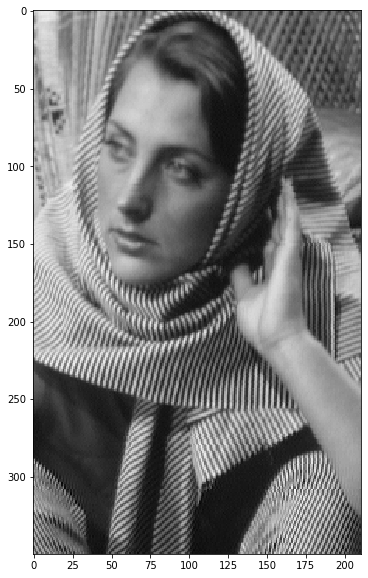

In [2]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction calculant l'échantillonnage

In [3]:
def echantillonne_image(inp,K,adjoint):
    sx , sy = np.shape(inp)  
    
    if adjoint==0:
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += inp[K*x+k,K*y+l]
                out[x,y]=tmp
                
    else:
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= inp[x,y]
           
    
    return out/(K*K)

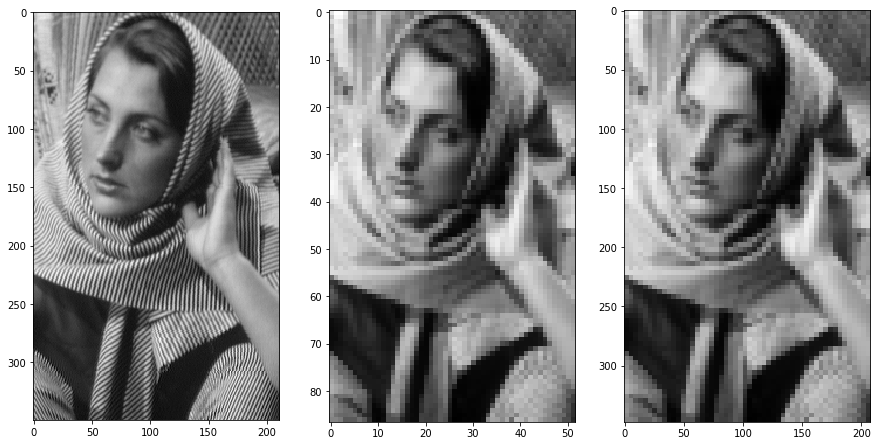

In [4]:
K=4
v = echantillonne_image(u,K,0)
w = echantillonne_image(v,K,1)

plt.figure(figsize = (15,30))
plt.subplot(1,3,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(v,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(w,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [5]:
def grad_x(img, adjoint):

    sx , sy = np.shape(img)
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[-1]=img[0]
        tmp[:-1]=img[1:]
    else:
        tmp[0]=img[-1]
        tmp[1:]=img[:-1]
    return tmp-img

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[:,-1]=img[:,0]
        tmp[:,:-1]=img[:,1:]
    else:
        tmp[:,0]=img[:,-1]
        tmp[:,1:]=img[:,:-1]
    return tmp-img

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
################################
def phi(img,beta):
    
    return np.sqrt(img+beta)

def phi_p(img,beta):

    return np.sqrt(1/(4*(img+beta)))
################################
def grad_TV(out,beta):
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi_p(tmpx*tmpx+tmpy*tmpy,beta)
    
    tmpx1 = grad_x(tmp*tmpx,1)
    tmpy1 = grad_y(tmp*tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1) 
    
    return grad
 
def TV(out,beta):
    sx , sy = np.shape(out)
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi(tmpx*tmpx+tmpy*tmpy,beta)
 
    return np.sum(np.abs(tmp))/(sx*sy)
################################


def projection(img,v,K):
    tmp = echantillonne_image(img,K,0)
    tmp1 = (K*K)*echantillonne_image(tmp-v,K,1)

    return img - tmp1

################################
  
def zoom_TV(v,K,nbIter):
    beta = 1
    pas = beta/4

    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_TV(out,beta)
        out = out - pas * d
        out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', TV(out,beta) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        
    return out

iter =  0 fonction =  4.397511875832635 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  4.316639739148102 max contrainte =  1.1368683772161603e-13
iter =  2 fonction =  4.257982626712461 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  4.212803761786331 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  4.176636363865245 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  4.1468426518428405 max contrainte =  1.4210854715202004e-13
iter =  6 fonction =  4.121746164574225 max contrainte =  1.1368683772161603e-13
iter =  7 fonction =  4.100226206267595 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  4.081502868660481 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  4.065015089965243 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  4.05034791331081 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  4.0371871637971175 max contrainte =  1.4210854715202004e-13
iter =  12 fonction =  4.

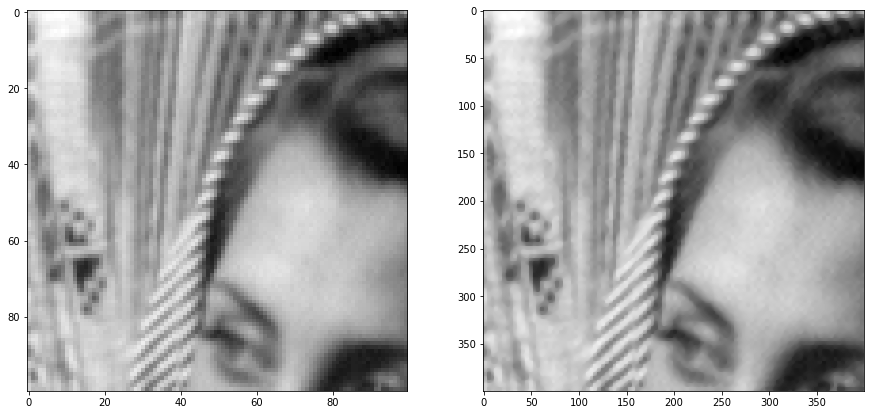

In [6]:
K=4
v = u[0:100,0:100] 
#v=np.copy(u)
#v = echantillonne_image(u,K,0)
w = zoom_TV(v,K,100)

plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(w,cmap='gray')


